In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time
from numba import jit

@jit(nopython=True)
def calculate_energy(img_gray):
    height, width = img_gray.shape
    energy = np.zeros((height, width), dtype=np.float32)

    for y in range(height):
        for x in range(width):
            if x == 0:
                dx = abs(float(img_gray[y, 1]) - float(img_gray[y, 0]))
            elif x == width-1:
                dx = abs(float(img_gray[y, x]) - float(img_gray[y, x-1]))
            else:
                dx = abs(float(img_gray[y, x+1]) - float(img_gray[y, x-1]))

            if y == 0:
                dy = abs(float(img_gray[1, x]) - float(img_gray[0, x]))
            elif y == height-1:
                dy = abs(float(img_gray[y, x]) - float(img_gray[y-1, x]))
            else:
                dy = abs(float(img_gray[y+1, x]) - float(img_gray[y-1, x]))

            energy[y, x] = dx + dy

    return energy

@jit(nopython=True)
def calculate_forward_energy(img_gray):
    height, width = img_gray.shape
    energy = np.zeros((height, width), dtype=np.float32)

    for y in range(1, height):
        for x in range(width):
            if x == 0:
                cu = abs(img_gray[y, x+1] - img_gray[y-1, x])
                cr = abs(img_gray[y, x+1] - img_gray[y-1, x]) + abs(img_gray[y-1, x+1] - img_gray[y-1, x])
                cl = 1000000
            elif x == width-1:
                cl = abs(img_gray[y, x-1] - img_gray[y-1, x])
                cl += abs(img_gray[y-1, x-1] - img_gray[y-1, x])
                cu = 0
                cr = 1000000
            else:
                cl = abs(img_gray[y, x-1] - img_gray[y-1, x])
                cl += abs(img_gray[y-1, x-1] - img_gray[y-1, x])
                cu = 0
                cr = abs(img_gray[y, x+1] - img_gray[y-1, x])
                cr += abs(img_gray[y-1, x+1] - img_gray[y-1, x])

            energy[y, x] = min(cl, cu, cr)

    return energy

@jit(nopython=True)
def calculate_cumulative_energy_map(energy):
    height, width = energy.shape
    cumulative_energy = np.copy(energy)

    for i in range(1, height):
        for j in range(width):
            if j == 0:
                cumulative_energy[i, j] += min(
                    cumulative_energy[i-1, j],
                    cumulative_energy[i-1, j+1]
                )
            elif j == width - 1:
                cumulative_energy[i, j] += min(
                    cumulative_energy[i-1, j-1],
                    cumulative_energy[i-1, j]
                )
            else:
                cumulative_energy[i, j] += min(
                    cumulative_energy[i-1, j-1],
                    cumulative_energy[i-1, j],
                    cumulative_energy[i-1, j+1]
                )

    return cumulative_energy

@jit(nopython=True)
def find_seam(cumulative_energy):
    height, width = cumulative_energy.shape
    seam = np.zeros(height, dtype=np.int32)

    j = np.argmin(cumulative_energy[height-1])
    seam[height-1] = j

    for i in range(height-2, -1, -1):
        j = seam[i+1]

        if j == 0:
            if cumulative_energy[i, j] <= cumulative_energy[i, j+1]:
                seam[i] = j
            else:
                seam[i] = j+1
        elif j == width - 1:
            if cumulative_energy[i, j-1] <= cumulative_energy[i, j]:
                seam[i] = j-1
            else:
                seam[i] = j
        else:
            if cumulative_energy[i, j-1] <= cumulative_energy[i, j] and cumulative_energy[i, j-1] <= cumulative_energy[i, j+1]:
                seam[i] = j-1
            elif cumulative_energy[i, j] <= cumulative_energy[i, j-1] and cumulative_energy[i, j] <= cumulative_energy[i, j+1]:
                seam[i] = j
            else:
                seam[i] = j+1

    return seam

@jit(nopython=True)
def remove_seam_fast(img_flat, seam, height, width, channels):
    new_width = width - 1
    new_img_flat = np.zeros((height, new_width, channels), dtype=np.uint8)

    for i in range(height):
        col = seam[i]
        for c in range(channels):
            for j in range(col):
                new_img_flat[i, j, c] = img_flat[i, j, c]
            for j in range(col, new_width):
                new_img_flat[i, j, c] = img_flat[i, j+1, c]

    return new_img_flat

def visualize_seam(img, seam):
    vis_img = np.copy(img)

    for i, j in enumerate(seam):
        if len(img.shape) == 3:
            vis_img[i, j] = [255, 0, 0]
        else:
            vis_img[i, j] = 255

    return vis_img

def carve_column(img):
    if len(img.shape) == 3:
        gray_img = np.mean(img, axis=2).astype(np.float32)
    else:
        gray_img = img.astype(np.float32)

    energy = calculate_energy(gray_img)
    forward_energy = calculate_forward_energy(gray_img)

    combined_energy = energy + forward_energy

    cumulative_energy = calculate_cumulative_energy_map(combined_energy)

    seam = find_seam(cumulative_energy)

    seam_img = visualize_seam(img, seam)

    height, width = img.shape[:2]
    if len(img.shape) == 3:
        channels = img.shape[2]
        carved_img = remove_seam_fast(img, seam, height, width, channels)
    else:
        channels = 1
        img_3d = img.reshape(height, width, channels)
        carved_img = remove_seam_fast(img_3d, seam, height, width, channels)
        carved_img = carved_img.reshape(height, width-1)

    return carved_img, seam_img, seam

def batch_carve_columns(img, num_cols, batch_size=10):
    result_img = np.copy(img)
    all_seams_vis = np.copy(img)
    all_seams = []

    num_batches = (num_cols + batch_size - 1) // batch_size

    for batch in range(num_batches):
        start_idx = batch * batch_size
        end_idx = min(start_idx + batch_size, num_cols)
        batch_size_actual = end_idx - start_idx

        print(f"Processing batch {batch+1}/{num_batches} (seams {start_idx+1}-{end_idx}/{num_cols})")
        batch_start_time = time.time()

        for i in range(batch_size_actual):
            result_img, seam_img, seam = carve_column(result_img)
            all_seams.append(seam)

            if i == 0 or i == batch_size_actual - 1:
                adjusted_seam = np.copy(seam)
                for s in range(len(seam)):
                    for prev_seam in all_seams[:-1]:
                        if prev_seam[s] <= seam[s]:
                            adjusted_seam[s] += 1

                if len(all_seams) == 1:
                    all_seams_vis = seam_img
                else:
                    for r, c in enumerate(adjusted_seam):
                        if c < all_seams_vis.shape[1]:
                            if len(all_seams_vis.shape) == 3:
                                all_seams_vis[r, c] = [255, 0, 0]
                            else:
                                all_seams_vis[r, c] = 255

        batch_time = time.time() - batch_start_time
        print(f"Batch completed in {batch_time:.2f} seconds ({batch_time/batch_size_actual:.2f} seconds per seam)")

    return result_img, all_seams_vis

def transpose_image(img):
    if len(img.shape) == 3:
        return np.transpose(img, (1, 0, 2))
    else:
        return np.transpose(img)

def resize_image(img, new_width, new_height):
    current_img = np.copy(img)

    if new_width < img.shape[1]:
        cols_to_remove = img.shape[1] - new_width
        print(f"Removing {cols_to_remove} columns...")
        current_img, _ = batch_carve_columns(current_img, cols_to_remove)

    if new_height < img.shape[0]:
        rows_to_remove = img.shape[0] - new_height
        print(f"Removing {rows_to_remove} rows...")
        current_img = transpose_image(current_img)
        current_img, _ = batch_carve_columns(current_img, rows_to_remove)
        current_img = transpose_image(current_img)

    return current_img




Please upload an image:


Saving input.jpg to input.jpg
Image loaded with shape: (200, 300, 3)
Resize by percentage or pixels? (percent/pixels): 
Enter new width (current: 300): 150
Enter new height (current: 200): 100
Resizing to 150x100...
Removing 150 columns...
Processing batch 1/15 (seams 1-10/150)
Batch completed in 4.28 seconds (0.43 seconds per seam)
Processing batch 2/15 (seams 11-20/150)
Batch completed in 0.06 seconds (0.01 seconds per seam)
Processing batch 3/15 (seams 21-30/150)
Batch completed in 0.07 seconds (0.01 seconds per seam)
Processing batch 4/15 (seams 31-40/150)
Batch completed in 0.05 seconds (0.00 seconds per seam)
Processing batch 5/15 (seams 41-50/150)
Batch completed in 0.05 seconds (0.00 seconds per seam)
Processing batch 6/15 (seams 51-60/150)
Batch completed in 0.03 seconds (0.00 seconds per seam)
Processing batch 7/15 (seams 61-70/150)
Batch completed in 0.04 seconds (0.00 seconds per seam)
Processing batch 8/15 (seams 71-80/150)
Batch completed in 0.07 seconds (0.01 seconds per

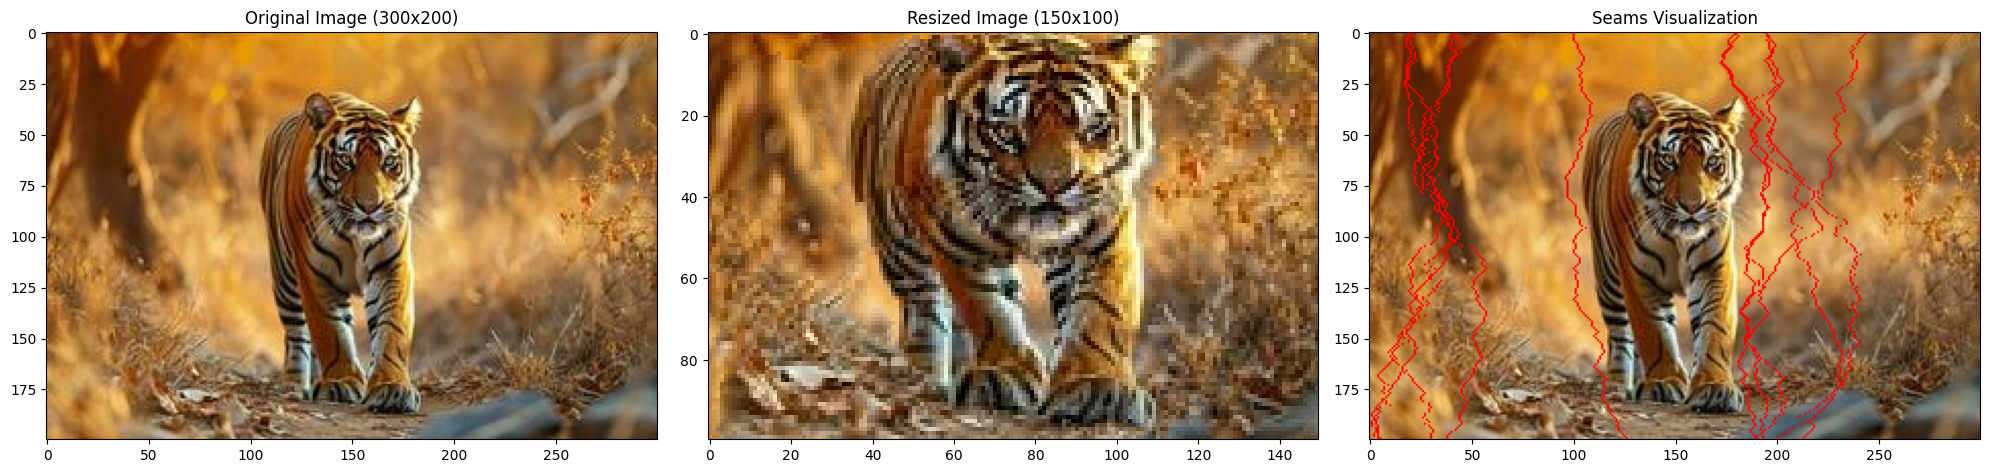

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Performance Report:
Original image size: 300x200 pixels
New image size: 150x100 pixels
Total pixels removed: 45000
Total processing time: 6.55 seconds
Processing speed: 6871.84 pixels/second


In [2]:
def main():
    from google.colab import files

    # Upload an image
    print("Please upload an image:")
    uploaded = files.upload()

    # Get the filename of the uploaded image
    image_path = next(iter(uploaded))

    # Load the image
    img = np.array(Image.open(image_path))
    original_shape = img.shape

    print(f"Image loaded with shape: {original_shape}")

    # Resize options
    resize_option = input("Resize by percentage or pixels? (percent/pixels): ").lower()

    if resize_option.startswith('p'):
        # Percentage-based resizing
        percent = float(input("Enter percentage of original size (e.g., 50 for half size): "))
        new_width = int(original_shape[1] * percent / 100)
        new_height = int(original_shape[0] * percent / 100)
    else:
        # Pixel-based resizing
        new_width = int(input(f"Enter new width (current: {original_shape[1]}): "))
        new_height = int(input(f"Enter new height (current: {original_shape[0]}): "))

    print(f"Resizing to {new_width}x{new_height}...")

    # Track total time
    start_time = time.time()

    # Resize the image
    resized_img = resize_image(img, new_width, new_height)

    # Create seam visualization for demonstration
    print("Creating seam visualization...")
    cols_to_show = min(50, original_shape[1] - new_width)  # Show at most 50 seams for clarity
    _, seams_visualization = batch_carve_columns(img, cols_to_show)

    total_time = time.time() - start_time
    print(f"Total time taken: {total_time:.2f} seconds")

    # Display results
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title(f"Original Image ({original_shape[1]}x{original_shape[0]})")

    plt.subplot(1, 3, 2)
    plt.imshow(resized_img)
    plt.title(f"Resized Image ({resized_img.shape[1]}x{resized_img.shape[0]})")

    plt.subplot(1, 3, 3)
    plt.imshow(seams_visualization)
    plt.title("Seams Visualization")

    plt.tight_layout()
    plt.show()

    # Save results
    output_filename = f"resized_{image_path}"
    seams_filename = f"seams_{image_path}"

    Image.fromarray(resized_img).save(output_filename)
    Image.fromarray(seams_visualization).save(seams_filename)

    # Download results
    print("Downloading results:")
    files.download(output_filename)
    files.download(seams_filename)

    # Performance report
    print("\nPerformance Report:")
    print(f"Original image size: {original_shape[1]}x{original_shape[0]} pixels")
    print(f"New image size: {resized_img.shape[1]}x{resized_img.shape[0]} pixels")
    pixels_removed = (original_shape[0] * original_shape[1]) - (resized_img.shape[0] * resized_img.shape[1])
    print(f"Total pixels removed: {pixels_removed}")
    print(f"Total processing time: {total_time:.2f} seconds")
    print(f"Processing speed: {pixels_removed / total_time:.2f} pixels/second")

if __name__ == "__main__":
    main()